<a href="https://colab.research.google.com/github/aayushxrj/Llama-2-7B-Chat-OpenOrca/blob/main/preprocessing_orca_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing necessary libraries and the dataset

In [ ]:
%%capture
!pip install pyarrow pandas

In [ ]:
import pandas as pd

In [ ]:
gpt4_data = pd.read_parquet('1M-GPT4-Augmented.parquet')
gpt4_data.head()

,id,system_prompt,question,response
0,niv.242684,,You will be given a definition of a task first...,"[\n [""AFC Ajax (amateurs)"", ""has ground"", ""Sp..."
1,flan.564327,You are an AI assistant. You will be given a t...,Generate an approximately fifteen-word sentenc...,Midsummer House is a moderately priced Chinese...
2,flan.1875913,"You are a helpful assistant, who always provid...",What happens next in this paragraph?\n\nShe th...,C. She then dips the needle in ink and using t...
3,t0.408370,You are an AI assistant. You will be given a t...,Please answer the following question: I want t...,"Based on the passage, discuss the primary moti..."
4,cot.86217,You are an AI assistant that helps people find...,James runs a TV show and there are 5 main char...,"James pays the minor characters $15,000 each e..."


In [ ]:
gpt3_5_data = pd.read_parquet('3_5M-GPT3_5-Augmented.parquet')
gpt3_5_data.head()


,id,system_prompt,question,response
0,t0.1791914,You are an AI assistant that follows instructi...,Q:The exercise is to decide whether the questi...,True.
1,flan.2203053,"You are a helpful assistant, who always provid...",Sentence 1: There is no need. \n\nSentence 2: ...,"Yes, if the first sentence is true, then the s..."
2,flan.1943030,"You are a helpful assistant, who always provid...",On his oak mantelpiece are a drinking bowl fro...,"We cannot conclude that the sentence ""The Ebol..."
3,t0.870962,You are an AI assistant that follows instructi...,Question: Read the following paragraph and ext...,"The full name of the person whose version of ""..."
4,t0.314926,You are an AI assistant that follows instructi...,I have a test where I am given the following a...,The Rova compound remained largely closed to t...


In [ ]:
# getting the length of both the datasets
print(f"There are {len(gpt4_data)} rows in the gpt4 dataset.")
print(f"There are {len(gpt3_5_data)} rows in the gpt3.5 dataset.")

There are 994896 rows in the gpt4 dataset.
There are 3239027 rows in the gpt3.5 dataset.


### Preprocessing function to drop rows with less than 100 tokens for the "`question`" column

In [ ]:
def preprocess(df):
    df['tokens'] = df['question'].apply(lambda x: len(x.split()))
    df_new = df[df['tokens'] > 100].copy()
    df_new.drop(["tokens"], axis=1, inplace=True)
    return df_new

In [ ]:
# Sampling and working with 1% dataset to speed up data analysis
df_sampled = gpt4_data.sample(frac=0.01,random_state=42)

In [ ]:
df_sampled_preprocessed = preprocess(df_sampled)
df_sampled_preprocessed.head(10)

,id,system_prompt,question,response
479803,flan.915371,You are an AI assistant. You will be given a t...,Choose how you want this story to end.\n\nIt's...,"In the wake of the heartbreaking tragedy, Basi..."
659207,t0.477447,You are an AI assistant. You will be given a t...,Q:I read this background article the other day...,Based on the information provided in the backg...
930172,flan.2028248,You are an AI assistant. User will you give yo...,Wonder Girls (Hangul: weondeogeolseu) was a So...,What awards did the Wonder Girls win at the 20...
450767,niv.124190,"You are a teacher. Given a task, you explain i...","Definition: Given an input stream, the objecti...",Task Explanation:\n1. Understand the objective...
519455,t0.106753,You are an AI assistant. Provide a detailed an...,Please answer the following question: Informat...,The novel 'Double Helix' by Nancy Werlin is re...
895568,flan.644870,"You are a helpful assistant, who always provid...",I hadn't been to Olive Garden in years and was...,This review would be described as negative sen...
976680,t0.1441057,You are an AI assistant. User will you give yo...,"Information: - Russia (from the Rus'), also ...",The entity with which 'peter troubetzkoy' exhi...
575501,t0.721612,You are an AI assistant. Provide a detailed an...,Q:The answer to the question: What are the fir...,The first names of the people whose employers ...
9237,t0.928784,You are an AI assistant. User will you give yo...,Please answer the following question: Please a...,Hayes infests the dwelling with cockroaches.
245708,t0.526021,,Q:Read the following article and select the be...,Hiding from the rain under a tree.


In [ ]:
# Preprocessing the gpt4 and gpt3.5 data
gpt4_data_preprocessed = preprocess(gpt4_data)
gpt3_5_data_preprocessed = preprocess(gpt3_5_data)


In [ ]:
# Further preprocessing and cleaning both the datasets to drop any rows with NA or " " values
gpt4_data_preprocessed.replace('', pd.NA, inplace=True)
gpt4_data_cleaned = gpt4_data_preprocessed.dropna(subset=['question', 'response'], how='any')

gpt3_5_data_preprocessed.replace('', pd.NA, inplace=True)
gpt3_5_data_cleaned = gpt3_5_data_preprocessed.dropna(subset=['question', 'response'], how='any')

In [ ]:
# getting the new length of both the datasets
print(f"There are {len(gpt4_data_cleaned)} rows in the gpt4 dataset after preprocessing.")
print(f"There are {len(gpt3_5_data_cleaned)} rows in the gpt3.5 dataset after preprocessing.")

There are 351003 rows in the gpt4 dataset after preprocessing.
There are 1435694 rows in the gpt3.5 dataset after preprocessing.


### Combining both dataframes to get a single dataframe

In [ ]:
# .sample() is used to shuffle the data
combined_df = pd.concat([gpt4_data_cleaned, gpt3_5_data_cleaned]).sample(frac=1, random_state=42)

### Data deduplication by doing grouping using cosine similarity (threshold>0.95)

In [ ]:
%%capture
!pip install scikit-learn tensorflow-hub numpy

In [ ]:
# Approch 1: using sklearn's TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

data = combined_df

texts = [row['question'] + ' ' + row['response'] for _, row in data.iterrows()]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(texts)

# Cosine Similarity Algorithm
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

threshold = 0.95
groups = defaultdict(list)

for i in range(len(data)):
    for j in range(i+1, len(data)):
        if cos_sim[i][j] > threshold:
            groups[i].append(j)
            groups[j].append(i)

# Merging the duplicates
merged_data = []
visited = set()
for i in range(len(data)):
    if i not in visited:
        merged_data.append(data.iloc[i])
        visited.add(i)
        for j in groups[i]:
            visited.add(j)


deduplicated_df = pd.DataFrame(merged_data)
deduplicated_df.head()

In [ ]:
# Approch 2: using Google's Universal Sentence Encoder

import tensorflow_hub as hub
import tensorflow_text
import numpy as np

data = combined_df

texts = [row['question'] + ' ' + row['response'] for _, row in data.iterrows()]

use_embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

embeddings = use_embed(texts)

# Cosine Similarity Algorithm
cos_sim = np.inner(embeddings, embeddings)

threshold = 0.95
groups = defaultdict(list)

for i in range(len(data)):
    for j in range(i+1, len(data)):
        if cos_sim[i][j] > threshold:
            groups[i].append(j)
            groups[j].append(i)

# Merging the duplicates
merged_data = []
visited = set()
for i in range(len(data)):
    if i not in visited:
        merged_data.append(data.iloc[i])
        visited.add(i)
        for j in groups[i]:
            visited.add(j)

deduplicated_df = pd.DataFrame(merged_data)
deduplicated_df.head()


In [ ]:
# Approch 3: using Google's Universal Sentence Encoder cmlm-en-large version

import tensorflow_hub as hub
import tensorflow_text
import numpy as np

data = combined_df

texts = [row['question'] + ' ' + row['response'] for _, row in data.iterrows()]

preprocessor = hub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/cmlm-en-large/versions/1")

use_embed = encoder(preprocessor(texts))["default"]

embeddings = use_embed(texts)

# Cosine Similarity Algorithm
cos_sim = np.inner(embeddings, embeddings)

threshold = 0.95
groups = defaultdict(list)

for i in range(len(data)):
    for j in range(i+1, len(data)):
        if cos_sim[i][j] > threshold:
            groups[i].append(j)
            groups[j].append(i)

# Merging the duplicates
merged_data = []
visited = set()
for i in range(len(data)):
    if i not in visited:
        merged_data.append(data.iloc[i])
        visited.add(i)
        for j in groups[i]:
            visited.add(j)

deduplicated_df = pd.DataFrame(merged_data)
deduplicated_df.head()


In [ ]:
# Optimized approach using Google's Universal Sentence Encoder cmlm-en-large version
import tensorflow_hub as hub
import tensorflow_text
import numpy as np
from collections import defaultdict
from scipy.sparse import lil_matrix

data = combined_df

texts = [row['question'] + ' ' + row['response'] for _, row in data.iterrows()]

use_embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2")

# Batching
batch_size = 1000
num_batches = (len(texts) + batch_size - 1) // batch_size

embeddings = []
for i in range(num_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(texts))
    batch_texts = texts[start:end]
    batch_embeddings = use_embed(batch_texts)
    embeddings.append(batch_embeddings)

embeddings = np.concatenate(embeddings, axis=0)

# Sparse Matrices
threshold = 0.95
groups = defaultdict(list)
cos_sim = lil_matrix((len(data), len(data)), dtype=np.float32)

for i in range(len(data)):
    for j in range(i+1, len(data)):
        similarity = np.inner(embeddings[i], embeddings[j])
        cos_sim[i, j] = cos_sim[j, i] = similarity
        if similarity > threshold:
            groups[i].append(j)
            groups[j].append(i)

# Merging the duplicates
merged_data = []
visited = set()
for i in range(len(data)):
    if i not in visited:
        merged_data.append(data.iloc[i])
        visited.add(i)
        for j in groups[i]:
            visited.add(j)

deduplicated_df = pd.DataFrame(merged_data)
deduplicated_df.head()

2024-04-01 17:38:30.691876: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-04-01 17:38:30.692327: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-01 17:38:30.692479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-01 17:38:30.692983: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-01 17:38:30.693001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-04-01 17:38:47.483971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# Checking for hoy many duplicates were found
print(f"Length of the combined_df Dataframe before deduplication: {len(combined_df)}")
print(f"Length of the deduplicated_df Dataframe after deduplication: {len(deduplicated_df)}")
print(f"{len(combined_df)-len(deduplicated_df)} duplicates found and merged.")

### Saving the new dataset as  "`preprocessed_Orca_dataset.parquet`"

In [ ]:
# deduplicated_df.to_parquet('preprocessed_Orca_dataset.parquet')     # Not using deduplicated dataset due to memory constraints
combined_df.to_parquet('preprocessed_Orca_dataset.parquet')

### Reformatting our dataset to follow Llama 2 template.

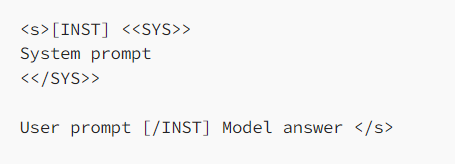

In [ ]:
def chat_template(row):
    instruction = f"### <s>[INST] <<SYS>> {row['system_prompt']} <</SYS>> {row['question']}[/INST] {row['response']} </s>"
    return instruction

instruction_list = combined_df.apply(chat_template, axis=1).tolist()

# Create a new DataFrame with the instructions to follow llama2 template
instruction_df = pd.DataFrame({'text': instruction_list})

instruction_df.head()

### Saving the new dataset as  "`instruction_preprocessed_Orca_dataset.parquet`"

In [ ]:
instruction_df.to_parquet('instruction_preprocessed_Orca_dataset.parquet')